In [1]:
from sklearn.tree import plot_tree
import seaborn as sns
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import numpy as np
from Levenshtein import distance as edit_distance
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import DBSCAN
import pm4py

In [2]:


# import data
def import_xes(file_path):
    event_log = pm4py.read_xes(file_path)
    start_activities = pm4py.get_start_activities(event_log)
    end_activities = pm4py.get_end_activities(event_log)
    print(
        "Start activities: {}\nEnd activities: {}".format(
            start_activities,
            end_activities))
    # convert all activity codes to strings
    event_log['Activity code'] = event_log['Activity code'].astype(str)
    return event_log


event_log = import_xes("data/Hospital_log.xes.gz")
print(type(event_log))
print(event_log)

parsing log, completed traces ::   0%|          | 0/1143 [00:00<?, ?it/s]

Start activities: {'1e consult poliklinisch': 71, 'inwend.geneesk.  korte kaart kosten-out': 8, 'verlosk.-gynaec. korte kaart kosten-out': 198, 'vervolgconsult poliklinisch': 234, 'verlosk.-gynaec.   jaarkaart kosten-out': 122, 'cytologisch onderzoek - ectocervix -': 28, 'echografie  - genitalia interna': 44, 'aanname laboratoriumonderzoek': 225, 'ligdagen - alle spec.beh.kinderg.-reval.': 39, 'telefonisch consult': 15, 'behandeltijd - eenheid t3 - megavolt': 1, 'ct abdomen': 2, 'behandeltijd - eenheid t2 - megavolt': 1, 'thorax': 12, 'e.c.g.      - elektrocardiografie': 63, 'cytologisch onderzoek - vagina -': 12, 'mammografie thoraxwand': 3, 'histologisch onderzoek - biopten nno': 19, 'dagverpleging - alle spec.beh.kind.-rev.': 5, 'inwend.geneesk.    jaarkaart kosten-out': 1, 'coupe ter inzage': 19, 'immunopathologisch onderzoek': 10, 'vagina      - scopie incl.evt.vulvabiops': 3, 'punctie tbv cytologisch onderzoek door p': 3, 'cytologisch onderzoek - buiktumorpunctie': 1, 'vrw.gesl.o

In [25]:


def label_function(log_df, required_activities):
    # Filter log to retain only traces with required activities
    filtered_df = pm4py.filtering.filter_event_attribute_values(
        log_df,
        attribute_key='concept:name',
        values=required_activities,
        level='case',
        retain=True,
        case_id_key='case:concept:name'
    )

    # Identify case IDs in the filtered DataFrame (these cases are normal)
    normal_cases = set(filtered_df['case:concept:name'].unique())

    # Create a dictionary mapping case IDs to 'normal' or 'deviant'
    case_labels = {
        case_id: 0 if case_id in normal_cases else 1
        for case_id in log_df['case:concept:name'].unique()
    }

    return case_labels


# Define required activities for this rule
required_activities_f1 = ['ca-19.9 tumormarker', 'ca-125 mbv meia']

# Generate the lf_map using the label function
lf_map = label_function(event_log, required_activities_f1)

The part below for the running trace is in comments since it is not used for the actual results. But, because a running trace is part of the framework it is included in this part. One improvement that could be made here is to extract prefixes first the running trace before the train/test, so it is possible to choose a trace with more than 1 element. This is not relevant to the actual framework though because a running trace should not come from the original training dataset. 

In [26]:


# Step 1: Sort traces temporally by the first event's timestamp and split 80/20
event_log_sorted = event_log.sort_values(by='time:timestamp')
print("Sorted Event Log:\n", event_log_sorted['case:concept:name'])


# Here, we sample one trace to represent a "running" trace. 
# running_trace = event_log_sorted.sample(1,random_state=17)
# event_log_sorted = event_log_sorted.drop(running_trace.index)

# Calculate the split index for 80% of the cases, without dropping duplicates
split_index = int(0.8 * len(event_log_sorted))

# Split the sorted event log directly
train_log = event_log_sorted.iloc[:split_index]
test_log = event_log_sorted.iloc[split_index:]

# Verify split sizes
print("Train log size:", len(train_log))
print("Test log size:", len(test_log))
# print("Running trace:\n", running_trace)

Sorted Event Log:
 0         00000000
374       00000004
375       00000004
377       00000004
378       00000004
            ...   
150289    00001142
75066     00000591
75065     00000591
60896     00000518
150290    00001142
Name: case:concept:name, Length: 150291, dtype: object
Train log size: 120232
Test log size: 30059


In [27]:


# Define a function to safely transform data using LabelEncoder, handling
# unknown values
def safe_transform(encoder, value):
    # Ensure "Missing" is in encoder classes
    if "Missing" not in encoder.classes_:
        encoder.classes_ = np.append(encoder.classes_, "Missing")

    # If the value is in the encoder's known classes, transform it; otherwise,
    # encode as "Missing"
    if value in encoder.classes_:
        return encoder.transform([value])[0]
    else:
        return encoder.transform(["Missing"])[0]

In [28]:


# Updated function with label_encoders as a parameter
def encode_data_attributes(
        event_log,
        prefixes_with_case_ids,
        attributes,
        label_encoders):
    encoded_data = []

    # Iterate over each (case_id, prefix)
    for case_id, prefix in prefixes_with_case_ids:
        # Get the last event in the current prefix
        last_event = prefix[-1]

        # Filter the event_log for the specific case and last event
        event_rows = event_log[
            (event_log['case:concept:name'] == case_id) &
            (event_log['Activity code'] == last_event)
        ]

        if event_rows.empty:
            print(
                f"No matching event found for case {case_id} and activity {last_event}")
            # Encode missing data explicitly as "Missing"
            data_vector = [
                safe_transform(
                    label_encoders[attr],
                    "Missing") for attr in attributes]
        else:
            # Take the first occurrence and encode each attribute
            event_row = event_rows.iloc[0]
            data_vector = [
                safe_transform(label_encoders[attr], str(event_row[attr]))
                for attr in attributes
            ]

        # Add the encoded vector to the results
        encoded_data.append(data_vector)

    return encoded_data

In [29]:


# Step 2: Extract prefixes from training set with specified step sizes
def extract_prefixes(trace, max_len=21, step=5):
    return [trace[:i] for i in range(1, max_len + 1, step) if i <= len(trace)]


# Group and extract prefixes from training traces
train_traces = train_log.groupby('case:concept:name')[
    'Activity code'].apply(list)
all_prefixes = train_traces.apply(lambda x: extract_prefixes(x)).explode()

In [30]:


# Initialize label encoders

X_cols = ['case:Diagnosis code', 'case:Treatment code']
label_encoders = {col: LabelEncoder() for col in X_cols}
for col in X_cols:
    # Fit encoders with the training log
    label_encoders[col].fit(train_log[col].astype(str))

# Encode each prefix individually
encoded_prefixes = []
for case_id, prefix in all_prefixes.items():
    # Encode attributes for each prefix and store
    encoded_prefix = encode_data_attributes(
        train_log, [(case_id, prefix)], X_cols, label_encoders)
    encoded_prefixes.append(encoded_prefix[0])  # Store each encoded prefix

In [31]:


# Convert each encoded prefix to a sequence for DBSCAN
sequence_encoded_prefixes = [
    ' '.join(map(str, encoded_prefix)) for encoded_prefix in encoded_prefixes]

In [10]:


# Step 3: Compute edit distance matrix for the training set only
n_train = len(sequence_encoded_prefixes)
train_distance_matrix = np.zeros((n_train, n_train))
for i in range(n_train):
    for j in range(i + 1, n_train):
        dist = edit_distance(
            sequence_encoded_prefixes[i],
            sequence_encoded_prefixes[j])
        train_distance_matrix[i, j] = dist
        train_distance_matrix[j, i] = dist  # Symmetric matrix

# Step 4: Apply DBSCAN on the training set using the specified parameters from the original paper
dbscan = DBSCAN(eps=0.125, min_samples=4, metric='precomputed')

# dbscan = DBSCAN(eps=0.15, min_samples=6, metric='precomputed')
# dbscan = DBSCAN(eps=0.2, min_samples=6, metric='precomputed')
train_cluster_labels = dbscan.fit_predict(train_distance_matrix)

In [11]:


# Columns used for classifier training
X_cols = ['case:Diagnosis code', 'case:Treatment code']

# Step 5: Train a classifier for each cluster in the training set
clusters = {}
for cluster_label in np.unique(train_cluster_labels):
    if cluster_label == -1:
        continue  # Skip noise points

    # Get indices of prefixes in the current cluster
    cluster_indices = [i for i, label in enumerate(
        train_cluster_labels) if label == cluster_label]

    # Prepare a list of (case_id, prefix) tuples
    prefixes_with_case_ids = [
        (all_prefixes.index[i], all_prefixes.iloc[i])
        for i in cluster_indices
    ]

    X_cluster = [encoded_prefixes[i] for i in cluster_indices]
    # Get labels for each prefix using lf_map
    y_cluster = [lf_map[case_id] for case_id, _ in prefixes_with_case_ids]

    # Print cluster size for inspection
    print(
        f"Cluster {cluster_label}: Size of X_cluster = {len(X_cluster)}, Size of y_cluster = {len(y_cluster)}")

    # Check if the cluster size is too small
    if len(X_cluster) <= 5:
        print(
            f"Warning: Cluster {cluster_label} has very few samples ({len(X_cluster)}). Consider adjusting DBSCAN parameters.")
        continue  # Skip clusters that are too small

    # Train decision tree classifier for the current cluster
    clf = DecisionTreeClassifier()
    clf.fit(X_cluster, y_cluster)
    clusters[cluster_label] = clf  # Store classifier by cluster label

Cluster 0: Size of X_cluster = 76, Size of y_cluster = 76
Cluster 1: Size of X_cluster = 30, Size of y_cluster = 30
Cluster 2: Size of X_cluster = 5, Size of y_cluster = 5
Cluster 3: Size of X_cluster = 30, Size of y_cluster = 30
Cluster 4: Size of X_cluster = 1552, Size of y_cluster = 1552
Cluster 5: Size of X_cluster = 10, Size of y_cluster = 10
Cluster 6: Size of X_cluster = 21, Size of y_cluster = 21
Cluster 7: Size of X_cluster = 106, Size of y_cluster = 106
Cluster 8: Size of X_cluster = 170, Size of y_cluster = 170
Cluster 9: Size of X_cluster = 35, Size of y_cluster = 35
Cluster 10: Size of X_cluster = 55, Size of y_cluster = 55
Cluster 11: Size of X_cluster = 211, Size of y_cluster = 211
Cluster 12: Size of X_cluster = 212, Size of y_cluster = 212
Cluster 13: Size of X_cluster = 139, Size of y_cluster = 139
Cluster 14: Size of X_cluster = 15, Size of y_cluster = 15
Cluster 15: Size of X_cluster = 89, Size of y_cluster = 89
Cluster 16: Size of X_cluster = 119, Size of y_cluster

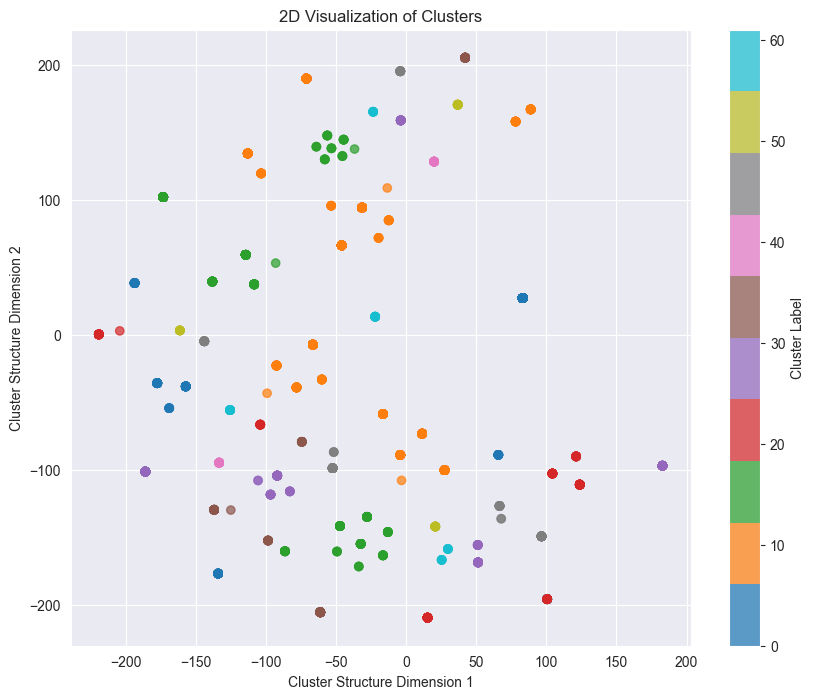

In [12]:


# Initialize placeholders for encoded clusters data and labels for
# visualization
encoded_clusters = []
cluster_labels = []

# Iterate over clusters and collect encoded data and corresponding labels
for cluster_label, clf in clusters.items():
    # Get indices of prefixes in the current cluster
    cluster_indices = [i for i, label in enumerate(
        train_cluster_labels) if label == cluster_label]

    # Collect the pre-encoded data for each cluster
    # encoded_prefixes should contain pre-encoded prefix data
    X_cluster = [encoded_prefixes[i] for i in cluster_indices]

    # Extend lists for t-SNE input and labels
    encoded_clusters.extend(X_cluster)
    cluster_labels.extend([cluster_label] * len(X_cluster))

# Convert encoded data to numerical format
encoded_clusters_numerical = []
for prefix in encoded_clusters:
    if isinstance(prefix, list):
        # Already in list format
        encoded_clusters_numerical.append(prefix)
    else:
        # Convert string to list of integers
        encoded_clusters_numerical.append(
            [int(feature) for feature in prefix.split()])

# Convert encoded_clusters_numerical to a NumPy array
encoded_clusters_numerical = np.array(encoded_clusters_numerical)

# Apply t-SNE for final 2D visualization
tsne = TSNE(n_components=2, random_state=17)
reduced_data = tsne.fit_transform(encoded_clusters_numerical)

# Plot the clusters
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    reduced_data[:, 0], reduced_data[:, 1], c=cluster_labels, cmap='tab10', alpha=0.7)
plt.colorbar(scatter, label='Cluster Label')
plt.title('2D Visualization of Clusters')
plt.xlabel('Cluster Structure Dimension 1')
plt.ylabel('Cluster Structure Dimension 2')
plt.show()

In [13]:


# Step 6: Define functions for finding the closest cluster and for
# reliable prediction

def find_closest_cluster(running_trace, train_prefixes, train_cluster_labels):
    # Convert running trace to sequence encoding
    running_sequence = ' '.join(map(str, running_trace))
    # Calculate edit distances between the running trace and each training
    # prefix
    distances = [edit_distance(running_sequence, train_seq)
                 for train_seq in train_prefixes]
    # Get the closest training prefix and its corresponding cluster label
    closest_idx = np.argmin(distances)
    closest_cluster = train_cluster_labels[closest_idx]
    return closest_cluster, closest_idx


def predict_with_reliability(
        clf,
        x_test,
        thresholds=[0.6],
        min_class_support=1):
    # Get the prediction probabilities for the test input
    probs = clf.predict_proba([x_test])[0]
    predicted_class = np.argmax(probs)
    class_support = np.sum(clf.classes_ == predicted_class)
    class_prob = probs[predicted_class]

    # Check reliability of the prediction based solely on probability
    # thresholds
    reliability_check = class_support >= min_class_support and any(
        class_prob >= t for t in thresholds)

    if reliability_check:
        return predicted_class, class_prob

    return None, None

In [14]:


# Inspect keys in lf_map
# Display the first few keys for inspection
print("Keys in lf_map:", list(lf_map.items()))

Keys in lf_map: [('00000000', 1), ('00000001', 1), ('00000002', 0), ('00000003', 1), ('00000004', 0), ('00000005', 1), ('00000006', 0), ('00000007', 0), ('00000008', 1), ('00000009', 0), ('00000010', 0), ('00000011', 0), ('00000012', 0), ('00000013', 1), ('00000014', 1), ('00000015', 1), ('00000016', 1), ('00000017', 0), ('00000018', 0), ('00000019', 1), ('00000020', 0), ('00000021', 1), ('00000022', 1), ('00000023', 0), ('00000024', 1), ('00000025', 1), ('00000026', 1), ('00000027', 0), ('00000028', 1), ('00000029', 1), ('00000030', 0), ('00000031', 1), ('00000032', 0), ('00000033', 0), ('00000034', 1), ('00000035', 1), ('00000036', 0), ('00000037', 1), ('00000038', 0), ('00000039', 0), ('00000040', 1), ('00000041', 1), ('00000042', 1), ('00000043', 1), ('00000044', 0), ('00000045', 0), ('00000046', 1), ('00000047', 0), ('00000048', 0), ('00000049', 1), ('00000050', 1), ('00000051', 1), ('00000052', 0), ('00000053', 1), ('00000054', 0), ('00000055', 1), ('00000056', 1), ('00000057', 1

In [15]:


# Store true and predicted labels
true_labels = []
predicted_labels = []
# Define the sequence of steps
step_sequence = [21, 16, 11, 6, 1]
max_prefix_length = 21  # Set the maximum prefix length
reliable_prediction_counter = 0
failed_prediction_counter = 0

# Iterate over each test trace with case IDs
for case_id, test_trace in test_log.groupby('case:concept:name')[
        'Activity code'].apply(list).items():
    reliable_prediction = False
    y_test = lf_map.get(case_id)  # Get true label for the test trace
    y_pred = None  # Initialize predicted label for the trace

    if y_test is None:
        print(f"Warning: No label found for {case_id} in lf_map")
        continue

    current_step = max_prefix_length
    while current_step > 0 and len(test_trace[:current_step]) <= max_prefix_length:
        current_prefix = test_trace[:current_step]

        # Encode the current prefix using encode_data_attributes, with
        # 'Missing' handling
        prefixes_with_case_ids = [(case_id, current_prefix)]
        X_test = encode_data_attributes(
            test_log,
            prefixes_with_case_ids,
            X_cols,
            label_encoders)[0]
        encoded_prefix = ' '.join(map(str, X_test))

        # Find the closest cluster by computing edit distances with training
        # encoded prefixes
        distances = [edit_distance(encoded_prefix, train_prefix)
                     for train_prefix in sequence_encoded_prefixes]
        closest_idx = np.argmin(distances)
        closest_cluster = train_cluster_labels[closest_idx]

        if closest_cluster == -1:
            # Move to the next prefix step if the closest cluster is noise
            current_step += step_sequence[0] if len(step_sequence) > 0 else 5
            continue

        # Retrieve the classifier for the closest cluster
        clf = clusters.get(closest_cluster)
        if clf:
            # Make a prediction with reliability checking
            y_pred, confidence = predict_with_reliability(clf, X_test)

            if y_pred is not None:
                print(
                    f"Reliable prediction achieved: {y_pred} with confidence {confidence}")
                reliable_prediction_counter += 1
                reliable_prediction = True
                break  # Stop if a reliable prediction is made

        # Move to the next step in the sequence
        current_step -= step_sequence.pop(0) if step_sequence else 5

    # Append the final true and predicted labels for evaluation
    true_labels.append(y_test)
    predicted_labels.append(y_pred if reliable_prediction else None)

    if not reliable_prediction:
        failed_prediction_counter += 1
        print(
            f"Prediction failure: No reliable prediction achieved for case {case_id}.")

Reliable prediction achieved: 0 with confidence 0.8333333333333334
Prediction failure: No reliable prediction achieved for case 00000005.
Prediction failure: No reliable prediction achieved for case 00000008.
Prediction failure: No reliable prediction achieved for case 00000012.
Prediction failure: No reliable prediction achieved for case 00000014.
Prediction failure: No reliable prediction achieved for case 00000015.
Prediction failure: No reliable prediction achieved for case 00000019.
Prediction failure: No reliable prediction achieved for case 00000021.
Prediction failure: No reliable prediction achieved for case 00000023.
Prediction failure: No reliable prediction achieved for case 00000029.
Reliable prediction achieved: 0 with confidence 1.0
Prediction failure: No reliable prediction achieved for case 00000032.
Prediction failure: No reliable prediction achieved for case 00000034.
Prediction failure: No reliable prediction achieved for case 00000038.
Prediction failure: No reliab

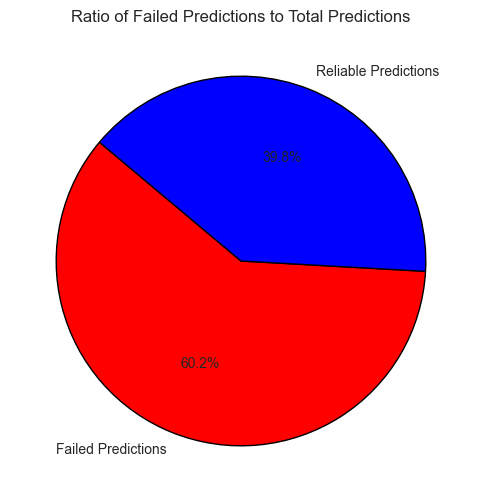

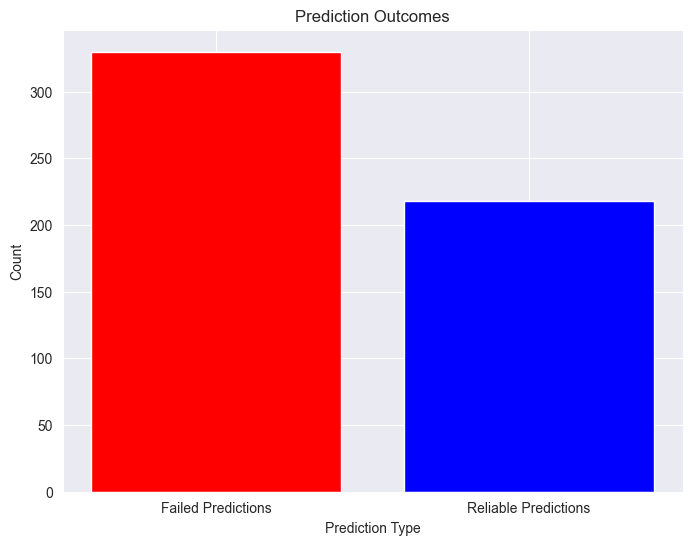

In [21]:


# Calculate total predictions
total_predictions = failed_prediction_counter + reliable_prediction_counter

# Data for visualization
labels = ['Failed Predictions', 'Reliable Predictions']
sizes = [failed_prediction_counter, reliable_prediction_counter]
colors = ['red', 'blue']

# Pie Chart
plt.figure(figsize=(8, 6))
plt.pie(
    sizes,
    labels=labels,
    colors=colors,
    autopct='%1.1f%%',
    startangle=140,
    wedgeprops={
        'edgecolor': 'black'})
plt.title("Ratio of Failed Predictions to Total Predictions")
plt.show()

# Alternatively, a bar chart if preferred
plt.figure(figsize=(8, 6))
plt.bar(labels, sizes, color=colors)
plt.xlabel('Prediction Type')
plt.ylabel('Count')
plt.title("Prediction Outcomes")
plt.show()

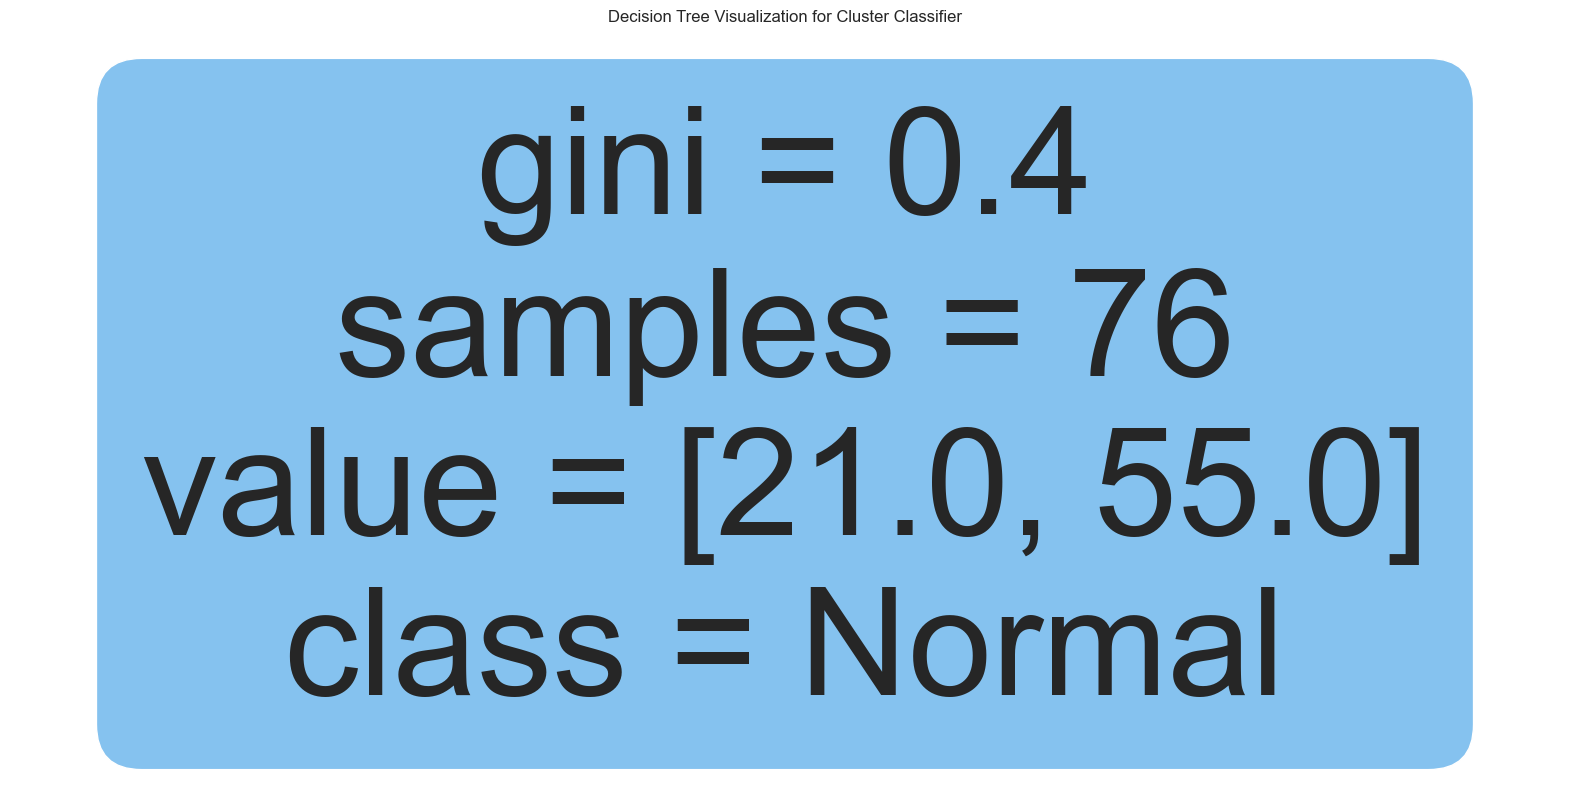

In [18]:
# Assuming `clf` is one of the trained decision tree classifiers

def visualize_decision_tree(clf, feature_names):
    plt.figure(figsize=(20, 10))
    plot_tree(
        clf,
        feature_names=feature_names,
        filled=True,
        rounded=True,
        class_names=[
            "Deviant",
            "Normal"])
    plt.title("Decision Tree Visualization for Cluster Classifier")
    plt.show()

if clf is not None:
    # Feature names would be the attributes used in the decision tree, for example:
    feature_names = X_cols  # ['case:Diagnosis code', 'case:Treatment code']
    visualize_decision_tree(clf, feature_names)

F1 Score: 0.714


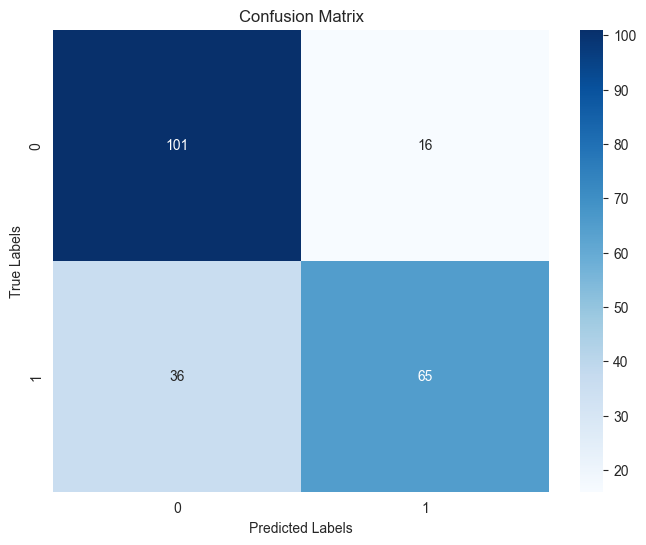

In [19]:


# Filter out cases where no reliable prediction was made (i.e., where
# y_pred is None)
filtered_true_labels = [
    y for y,
    pred in zip(
        true_labels,
        predicted_labels) if pred is not None]
filtered_predicted_labels = [
    pred for pred in predicted_labels if pred is not None]

# Check if there are any valid predictions left for evaluation
if filtered_predicted_labels:
    # Evaluate the predictions
    f1 = f1_score(
        filtered_true_labels,
        filtered_predicted_labels,
        average='binary')
    print(f'F1 Score: {f1:.3f}')

    # Plot the confusion matrix
    cm = confusion_matrix(filtered_true_labels, filtered_predicted_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues', xticklabels=[
            0, 1], yticklabels=[
            0, 1])  # Updated labels to match integer encoding
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()
else:
    print("No valid predictions to evaluate. Check clustering, classifier training, or reliability criteria.")

## The code below could be used to predict a running trace. This is not required to test F1 score for our final results but it is part of the framework so it is meaningful to add it as part of our code even in comments.

In [ ]:


'''
# Step 1: Preprocess and encode the running trace using the same method as train/test data
X_cols = ['case:Diagnosis code', 'case:Treatment code']
#label_encoders = {col: LabelEncoder().fit(train_log[col].fillna("Missing").astype(str)) for col in X_cols}

# Extract prefixes from the running trace
running_trace_case_id = running_trace['case:concept:name'].iloc[0]
running_trace_activities = running_trace[running_trace['case:concept:name'] == running_trace_case_id]['Activity code'].tolist()

# Step 2: Iterate over prefixes of the running trace and make predictions
for i in range(1, len(running_trace_activities) + 1):
    current_prefix = running_trace_activities[:i]
    print(f"\n--- Prefix Length {i} ---")
    print("Current Prefix:", current_prefix)

    # Encode the current prefix
    encoded_prefix = encode_data_attributes(running_trace, [(running_trace_case_id, current_prefix)], X_cols, label_encoders)[0]
    encoded_prefix_str = ' '.join(map(str, encoded_prefix))

    # Find the closest cluster by computing edit distances with training encoded prefixes
    distances = [edit_distance(encoded_prefix_str, train_prefix) for train_prefix in sequence_encoded_prefixes]
    closest_idx = np.argmin(distances)
    closest_cluster = train_cluster_labels[closest_idx]

    if closest_cluster == -1:
        print("Closest cluster is noise, skipping this prefix.")
        continue

    # Retrieve the classifier for the closest cluster
    clf = clusters.get(closest_cluster)
    if clf:
        # Predict the label using the classifier of the closest cluster
        y_pred, confidence = predict_with_reliability(clf, encoded_prefix)
        print(f"Predicted label for prefix {i}: {y_pred} with confidence: {confidence}")
    else:
        print("No classifier available for the closest cluster.")

        '''

In [ ]:


'''
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Assuming `clf` is one of the trained decision tree classifiers
def visualize_decision_tree(clf, feature_names):
    plt.figure(figsize=(20, 10))
    plot_tree(clf, feature_names=feature_names, filled=True, rounded=True, class_names=["Deviant", "Normal"])
    plt.title("Decision Tree Visualization for Cluster Classifier")
    plt.show()

# Feature names would be the attributes used in the decision tree, for example:
feature_names = X_cols  # ['case:Diagnosis code', 'case:Treatment code']
visualize_decision_tree(clf, feature_names)
'''